# Stochastic Bernoulli Bandits

Implementation of epsilon-greedy, UCB1 and Thompson sampling to this bandit problem

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
sns.set()

In [17]:
class BernoulliBandit:
    def __init__(self, means):
        self.means = np.array(means)
        self.gaps = np.max(means) - means        
            
    def K(self):
        return len(self.means)
    
    def pull(self, a):
        proba = self.means[a]
        #self.regret_seq.append(self.gaps[a]) 
        if np.random.rand(1)[0] < proba:
            return 1
        else:
            return 0


In [18]:
class EpsilonGreedySolver:
    def __init__(self, epsilon, K):
        self.num_arms = K
        self.eps = epsilon
        
        # change to ones if you want Optimistic Initialization
        self.action_value_est = np.zeros((K,1))
        self.number_pulls_a = np.zeros((K,1))
        self.r_seq = []
        self.regret_seq = []
        
    def choose_action(self):
        
        if np.random.rand(1)[0] > self.eps:
            a = np.argmax(self.action_value_est)
        else:
            a = np.random.choice(self.num_arms)
            
        return a
    
    def step(self, bandit):
        
        a = self.choose_action()
        r = bandit.pull(a)
        self.r_seq.append(r)
        self.update_regret(bandit, a)
        
        self.number_pulls_a[a] += 1
        self.action_value_est[a] =  self.action_value_est[a] + (r - self.action_value_est[a])/(self.number_pulls_a[a])
            
    def overall_regret(self):
        return np.cumsum(self.regret_seq)
    
    def update_regret(self, bandit, a):
        self.regret_seq.append(bandit.gaps[a]) 
        

In [19]:
class UCB1Solver:
    def __init__(self, K):
        self.num_arms = K
        self.action_value_est = np.zeros((K,1))
        self.upper_conf_est = np.full((K, 1), np.inf)
        self.number_pulls_a = np.zeros((K,1))
        self.total_pulls = 0
        self.r_seq = []
        self.regret_seq = []
        
    def choose_action(self):
        
        a = np.argmax(self.action_value_est + self.upper_conf_est)
        return a
    
    def step(self,bandit):
        
        a = self.choose_action()
        r = bandit.pull(a)
        self.update_regret(bandit, a)
        
        self.r_seq.append(r)
        
        self.total_pulls += 1
        self.number_pulls_a[a] += 1
        
        self.action_value_est[a] =  self.action_value_est[a] + (r - self.action_value_est[a])/(self.number_pulls_a[a])
        self.upper_conf_est = np.sqrt(2 * np.log(self.total_pulls)/(self.number_pulls_a + 1e-16))
        
    def overall_regret(self):
        return np.cumsum(self.regret_seq)
    
    def update_regret(self, bandit, a):
        self.regret_seq.append(bandit.gaps[a]) 
        

In [20]:
class ThompsonSampling:
    def __init__(self, K, alpha = 1, beta = 1):
        self.num_arms = K
        self.action_value_post = np.zeros((K,2))
        
        self.action_value_post[:,0] = alpha
        self.action_value_post[:,1] = beta
        
        self.r_seq = []
        self.regret_seq = []
        
    def choose_action(self):
        
        samples = []
        for i in range(self.num_arms):
            samples.append(np.random.beta(self.action_value_post[i,0],self.action_value_post[i,1],1)[0])
        
        a = np.argmax(samples)
        return a
    
    def step(self, bandit):
        
        a = self.choose_action()
        r = bandit.pull(a)
        self.update_regret(bandit, a)
        
        self.r_seq.append(r)
        
        if r == 1:
            self.action_value_post[a,0] += 1
        else:
            self.action_value_post[a,1] += 1
            

    def overall_regret(self):
        return np.cumsum(self.regret_seq)
    
    def update_regret(self, bandit, a):
        self.regret_seq.append(bandit.gaps[a])

In [21]:
#Create the specific problem instance

mean_prob_arr = [0.8, 0.3, 0.5, 0.1, 0.25, 0.7,0.9]
bd = BernoulliBandit(mean_prob_arr)

In [22]:
print("Number of arms:",bd.K())

Number of arms: 7


In [23]:
num_trials = 20000

In [24]:
egreedy = EpsilonGreedySolver(0.1, bd.K())
for t in range(num_trials):
    egreedy.step(bd)

In [25]:
egreedy.action_value_est

array([[0.78640777],
       [0.31707317],
       [0.47323944],
       [0.11409396],
       [0.23591549],
       [0.66903915],
       [0.9011779 ]])

In [26]:
ucb1 = UCB1Solver(bd.K())
for t in range(num_trials):
    ucb1.step(bd)

In [27]:
thompson = ThompsonSampling(bd.K())
for t in range(num_trials):
    thompson.step(bd)

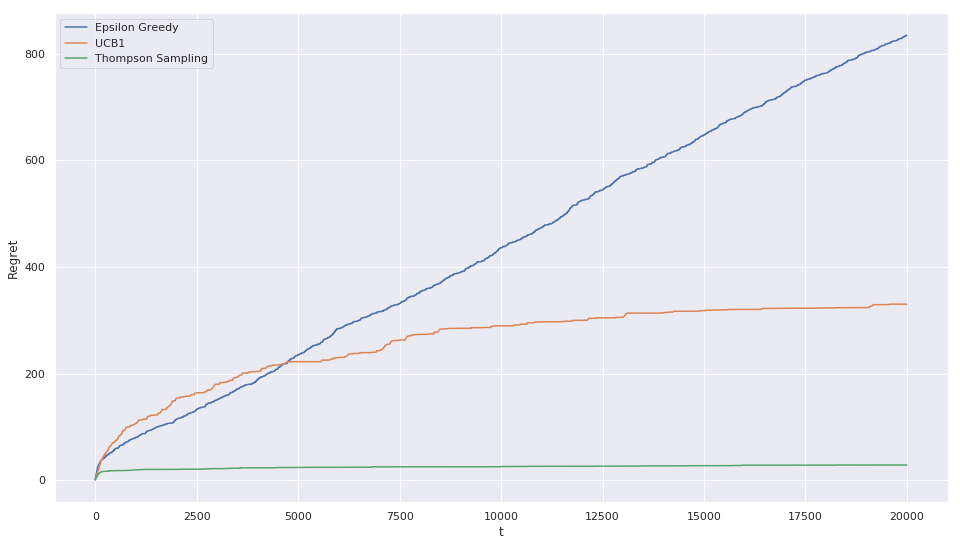

In [28]:
plt.figure(figsize = (16,9))
plt.plot(egreedy.overall_regret(), label="Epsilon Greedy")
plt.plot(ucb1.overall_regret(), label="UCB1")
plt.plot(thompson.overall_regret(), label="Thompson Sampling")
plt.xlabel("t")
plt.ylabel("Regret")
plt.legend()

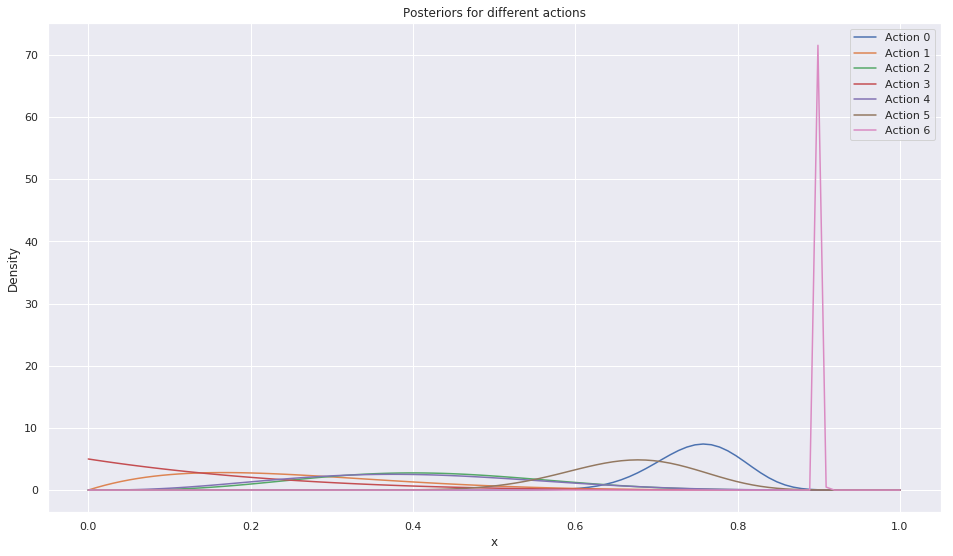

In [29]:
plt.figure(figsize = (16,9))
for ak in range(thompson.num_arms):
    a = thompson.action_value_post[ak,0]
    b = thompson.action_value_post[ak,1]
    x = np.linspace(0,1,100)
    y = beta.pdf(x,a,b)
    plt.plot(x,y, label = "Action " + str(ak))
    
plt.title("Posteriors for different actions")
plt.ylabel("Density")
plt.xlabel("x")
plt.legend()